# Genodesic Tutorial on the Schiebinger Dataset

This notebook demonstrates the end-to-end **Genodesic** pipeline for trajectory reconstruction. Our goal is to find a biologically meaningful path between two cell states in the Schiebinger dataset. We achieve this by computing a geodesic with respect to a data-density-aware Fermat metric, which ensures the path realistically follows the underlying data manifold.

The analysis is broken down into four key stages:

1.  **Data Preparation:** We begin by downloading the dataset, selecting the most informative Highly Variable Genes (HVGs), and training an autoencoder to project the high-dimensional count data into a more manageable latent space. This creates the space where our analysis will take place.

2.  **Score-Based Density Modeling:** We then train the core of our method, a VP-SDE model, on this latent space. This model learns the data's score field ($s = \nabla_x \log p$), which is the essential gradient information used to guide the pathfinding process.

3.  **Geodesic Computation:** With the score model in hand, we select start and end cells from different timepoints. We find an initial path proposal using a density-aware graph search and then iteratively refine this guess into a smooth geodesic using our learned score function.

4.  **Analysis & Validation:** Finally, we evaluate the properties of our initial and refined paths. We will analyze their length and density profiles and, most importantly, compare their progression against the dataset's known "wall-clock time" to validate the biological plausibility of our reconstructed trajectory.

## Global Notebook Configuration

This section contains all the key parameters for the entire pipeline. It's the main control panel for this notebook.

**Default Parameters & Overrides:**
The Genodesic package uses YAML files (`Config/models.yaml` and `Config/refinement.yaml`) to store default hyperparameters for training and path refinement. Below, we define Python dictionaries that override these defaults for specific experiments.

In [1]:
import os
import torch

# --- A. Global Toggles & Setup ---
ReextractHVGs = False
RetrainAutoencoder = False
RetrainDensity = False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- B. Define Core Parameters ---
# Parameters that influence multiple steps and filenames
TRUNK = "both"
N_HVG = 2000
BOTTLENECK_DIM = 24
MODEL_TYPE = "otcfm"  # Options: "vpsde", "otcfm", "rqnsf"

# --- C. Dynamically Generate All File Paths ---
# This is now explicit. We know exactly what files we expect.
hvg_output_file = f"schiebinger_hvg_tensor_trunk-{TRUNK}_{N_HVG}hvg.pt"
hvg_tensor_path = os.path.join("Pipeline/HVGs", hvg_output_file)

ae_model_save_path = f"Models/Autoencoder/trunk-{TRUNK}_dim-{BOTTLENECK_DIM}_hvg-{N_HVG}.pt"
latent_save_path = f"LatentSpace/trunk-{TRUNK}_dim-{BOTTLENECK_DIM}_hvg-{N_HVG}_latent.pt"
density_model_save_path = f"Models/DensityModels/{MODEL_TYPE}_trunk-{TRUNK}_dim-{BOTTLENECK_DIM}.pt"

# --- D. Define All Overrides in ONE Structured Dictionary ---
# This structure mirrors the YAML files, making the deep_merge work perfectly.
notebook_overrides = {
    "hvg_extraction": {
        "output_file": hvg_output_file,
        "trunk": TRUNK,
        "n_hvg": N_HVG,
        "min_counts": 2000,
        "max_counts": 50000,
        "min_cells": 50,
    },
    "autoencoder": {
        "model_save_path": ae_model_save_path,
        "latent_save_path": latent_save_path,
        "bottleneck_dim": BOTTLENECK_DIM,
        "num_epochs": 50,
        "learning_rate": 0.0005,
    },

    "density_model": {
        "model_type": MODEL_TYPE,
        "data_file": latent_save_path,
        "model_save_path": density_model_save_path,
        "dim": BOTTLENECK_DIM,
        "num_epochs": 3,
        "batch_size": 512,
    }
}

# 0: Downloading the Schiebinger Dataset

We first download and extract the Schiebinger Dataset. As this can be a bit tricky, we provide a shell script that automatically downloads the entire dataset and extracts it to Data/Schiebinger. If a dataset is already found at that path, the download is skipped.

In [2]:
%%bash
./SchiebingerDownload.sh

--- Schiebinger Dataset Downloader ---
Directory Data/Schiebinger already exists and is not empty.
Continuing: will attempt to extract/unpack any archives found in this directory.
Skipping cleanup as no new download was performed.
---
Dataset is located in: Data/Schiebinger


# 1: Extracting HVGs of chosen Branch

We now combine all datasets and filter for the desired branch. Afterwards we run HVG extraction and save the new combined HVG count matrix to disk. Per default the extraction is skipped if the count matrix already exists. The boolean `ReextractHVGs` overwrites this check. 


In [3]:
from Genodesic.Utils import load_config
from Pipeline.firstSelectHVGs import run_hvg_extraction
import matplotlib.pyplot as plt

if os.path.exists(hvg_tensor_path) and not ReextractHVGs:
    print(f"File {hvg_output_file} already exists. Skipping.")
else:
    print("Starting HVG extraction...")
    # 1. Load base config and merge overrides
    hvg_config = load_config(
        default_config_path='Config/hvg_extraction.yaml',
        overrides=notebook_overrides
    )
    # 2. Run the extraction
    hvg_fig = run_hvg_extraction(
        config=hvg_config,
        data_dir="Data/Schiebinger",
        debug=True
    )
    if hvg_fig: plt.show()

File schiebinger_hvg_tensor_trunk-both_2000hvg.pt already exists. Skipping.


# 2: Training the Autoencoder

In [4]:
from Pipeline.secondTrainAutoencoder import run_autoencoder_training

if os.path.exists(ae_model_save_path) and not RetrainAutoencoder:
    print(f"Model already exists at {ae_model_save_path}. Skipping training.")
else:
    print("Starting autoencoder training...")
    # 1. Load base config and merge overrides
    ae_config = load_config(
        default_config_path='Config/autoencoder.yaml',
        overrides=notebook_overrides
    )
    # 2. Run the training
    run_autoencoder_training(
        hvg_tensor_file=hvg_tensor_path,
        config=ae_config,
        debug=False
    )

Model already exists at Models/Autoencoder/trunk-both_dim-24_hvg-2000.pt. Skipping training.


## 2.1: Visualizing the Latent Space

In [5]:
from Genodesic.Visualizers import UMAP3D

latent_data_bundle = torch.load(latent_save_path)

# Extract the numpy arrays for plotting
latent_reps = latent_data_bundle['latent_reps'].numpy()
timepoints = latent_data_bundle['timepoints'].numpy().flatten()



print(f"Loaded {latent_reps.shape[0]} latent vectors.")

UMAP3D(
    latent_reps=latent_reps,
    color_by_timepoints=timepoints,
    title=f"Latent Space UMAP (Trunk: {TRUNK})"
)

cuML found. Using GPU for UMAP acceleration.
Loaded 249047 latent vectors.
--- Starting 3D Visualization ---
Fitting UMAP model...
Creating k3d plot...
Coloring by continuous timepoints and adding a color bar.
--- Visualization Complete ---


Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

# 3: Setting up Density Models

In [6]:
from Scripts.train import run_training
from Genodesic.Utils import load_density_model_from_checkpoint

if os.path.exists(density_model_save_path) and not RetrainDensity:
    model = load_density_model_from_checkpoint(density_model_save_path, device=DEVICE)
else:
    print("Starting density model training...")
    density_config = load_config(
        default_config_path='Config/DensityModels.yaml',
        overrides=notebook_overrides.get("density_model", {})
    )
    model = run_training(config=density_config)

print(f"\nSuccessfully loaded model: {model.__class__.__name__}")


Loading model of type 'otcfm' from Models/DensityModels/otcfm_trunk-both_dim-24.pt...

Successfully loaded model: OptimalFlowModel


# Trajetories

## Initialization

First we choose the start and end time and then sample two random cells from the subsamples that are to be connected

In [7]:
import numpy as np

# Your chosen start and end timepoints
start_time = 3
end_time = 15

# Find indices for each timepoint
start_idx = np.random.choice(np.where(timepoints == start_time)[0])
end_idx = np.random.choice(np.where(timepoints == end_time)[0])


We now initialize a path between the two sampled cells by performing a Dijkstra on the knn graph of the dataset:

In [8]:
# from Genodesic.PathTools import find_dijkstra_path
# 
# init_path = find_dijkstra_path(start_idx, end_idx, latent_reps)
# UMAP3D(
#     paths=[init_path],
#     latent_reps=latent_reps,
#     color_by_timepoints=timepoints
# )

## Refinement

In [9]:
# from Genodesic.PathTools import run_refinement_loop
# 
# refined_path = run_refinement_loop(
#     phi_initial=init_path,
#     model=model
# )


In [10]:
# from Genodesic.PathTools import DensityBasedResampling
# 
# resampled_path = DensityBasedResampling(
#     phi=torch.from_numpy(init_path),
#     model=model,
#     num_points=100,
#     beta = -1/4
# )

In [11]:
# from Genodesic.Visualizers import UMAP3D
# 
# UMAP3D(
#     paths=[init_path, refined_path],
#     latent_reps=latent_reps,
#     color_by_timepoints=timepoints
# )

In [12]:
# phi_initial = torch.from_numpy(init_path)
# phi_relaxed = resampled_path
# 
# # Save the path tensors to disk
# torch.save({
#     'phi_initial': phi_initial,
#     'phi_relaxed': phi_relaxed
# }, 'Genodesic_tutorial_paths.pt')
# 

In [13]:
import torch
# Load the saved paths
saved_paths = torch.load('Genodesic_tutorial_paths.pt')
phi_initial = saved_paths['phi_initial']
phi_relaxed = saved_paths['phi_relaxed']


--- Calculating Path Statistics ---
Processing 'Initial Path'...


/home/slaus/Genodesic/Genodesic/DensityModels/OT_CFM.py:126: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/envs/genodesic/lib/python3.11/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Processing 'Relaxed Path'...
Calculations complete.



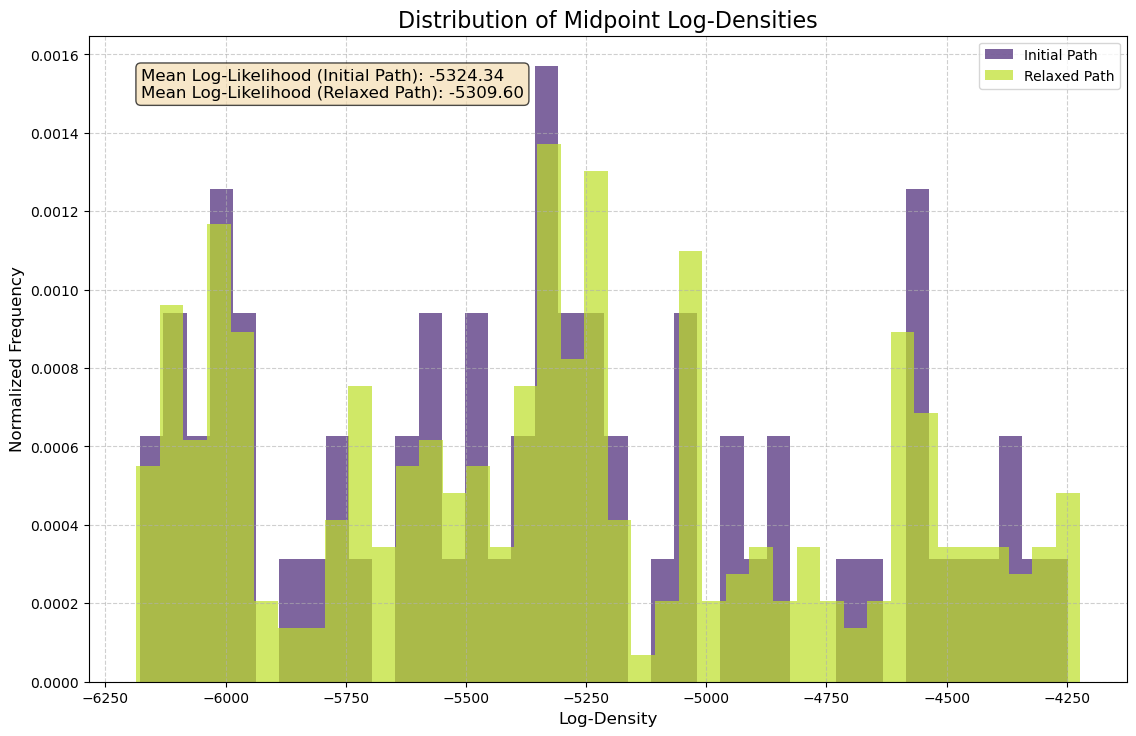

--- Path Statistics ---

Initial Path:
  Euclidean Length: Mean=3.115, Std=0.421, Min=2.478, Max=3.981, Total=68.531
  Log-Density:      Mean=-5324.337, Std=548.641
  Fermat Length:    0.000 (beta=-0.25)

Relaxed Path:
  Euclidean Length: Mean=0.664, Std=0.067, Min=0.397, Max=0.692, Total=65.784
  Log-Density:      Mean=-5309.597, Std=555.344
  Fermat Length:    0.000 (beta=-0.25)

--- Total Arc Length Comparison ---
Reference Path: 'Initial Path' (Total Length: 68.531)
  vs. 'Relaxed Path': 65.784 (Change: -4.01%)


In [14]:
from Genodesic.PathTools import calculate_path_statistics

paths_to_analyze = {
    'Initial Path': phi_initial,
    'Relaxed Path': phi_relaxed
}

path_statistics = calculate_path_statistics(
    paths_dict=paths_to_analyze,
    model=model,
    beta_param=-1/4,
    integration_steps=2
)

from Genodesic.PathTools import report_path_statistics
report_path_statistics(
    stats_dict=path_statistics,
    reference_path_name='Initial Path',
    beta_param=-1/4,  
)

In [15]:
from Genodesic.PathTools import DensityBasedResampling

resampled_path = DensityBasedResampling(
    phi=phi_initial,
    model=model,
    num_points=150,
    beta = 4
)

test_path = DensityBasedResampling(
    phi=phi_initial,
    model=model,
    num_points=100,
    beta = -4
)

Computing average pseudotime along path (k=10)...
Computing average pseudotime along path (k=10)...
Computing average pseudotime along path (k=10)...
Plotting multiple pseudotime progressions on a normalized axis...


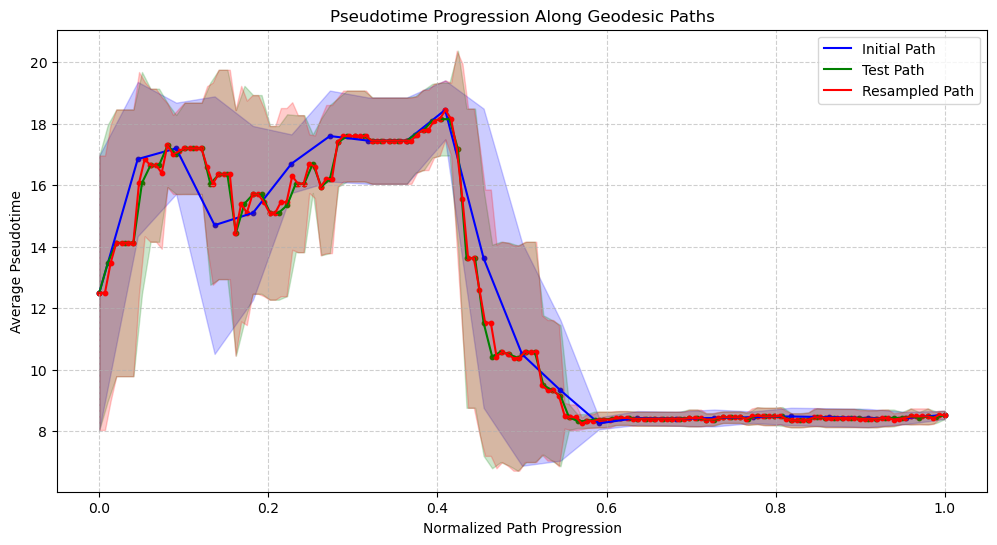

In [16]:
from Genodesic.PathTools.Wallclock import compute_path_pseudotime

avg_initial, std_initial = compute_path_pseudotime(
    phi_initial, latent_reps, timepoints, k=10
)

# avg_relaxed, std_relaxed = compute_path_pseudotime(
#     refined_path, latent_reps, timepoints, k=10
# )

avg_relaxed, std_relaxed = compute_path_pseudotime(
    test_path, latent_reps, timepoints, k=10
)

avg_resampled, std_resampled = compute_path_pseudotime(
    resampled_path, latent_reps, timepoints, k=10
)

# 2. Collect all results into a single list of tuples
all_results = [
    (avg_initial, std_initial, 'Initial Path'),
    (avg_relaxed, std_relaxed, 'Test Path'),
    (avg_resampled, std_resampled, 'Resampled Path')
]

from Genodesic.PathTools.Diagnostics import plot_pseudotime_progressions

# 3. Call the modified plotting function once with all the data
plot_pseudotime_progressions(
    all_results, 
    colors=['blue', 'green', 'red']
)